<a href="https://colab.research.google.com/github/sroy890/Airline-scanner-failure-prediction/blob/main/Scanner_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance  - Classification approach

**Task 1 - build a model to answer a question**

question: Model the err, and errf columns for individual 'scanners' to show a expected failure rate of the encoder component. 
Scanners identified into two groups, based on the following criteria and grouping:
never fail: scanners whom never reach the 12 % range for err
routinely fail: scanners whom reach the 12% range for err on a routine basis
err and errf are both float values, they are loosely tied to each other, and are not a 1 for 1 relationship, e.g. a rising err value doesn't mean a errf value will rise, nor the opposite.  
Failure is defined as a err that is above 12 % and/or a errf that is above 0.5 %

background:  err and errf represent a encoder error rate at which a led light is pulsating into a window barrier.  This barrier, and subsequent calculation, represent the rate of rotation of a component, and the compensated ERRor and ERRor Filtered value.  

**task 2 - explain why the model was chosen to answer the question asked**

**task 3- explain the performance of the model, and of other models that would prove the same question.**

**task 4 -: Build documentation and share it across.**

In [209]:
from google.colab import files


uploaded = files.upload()

Saving encoders (1).csv to encoders (1) (2).csv


In [206]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import statsmodels.api as sm

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio 
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [208]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [207]:
plt.rcParams["figure.figsize"] = (15,4)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
df = pd.read_csv('encoders (1).csv', parse_dates=['date'], infer_datetime_format= True)

In [ ]:
df.head(3)

,id,date,scanner,min,max,err,pixels,minf,maxf,errf,created_at,updated_at
0,12,2017-12-17,K219,35435,35933,1.40,6,35681,35688,0.02,NaN,26:16.5
1,30,2017-12-18,H161,35155,36382,3.43,14,35731,35761,0.08,NaN,26:16.9
2,47,2017-12-18,K211,35305,36042,2.07,43,35692,35739,0.13,NaN,10:57.5


In [ ]:
df.drop(['created_at','id'], axis=1, inplace= True)

In [ ]:
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        2752 non-null   datetime64[ns]
 1   scanner     2752 non-null   object        
 2   min         2752 non-null   int64         
 3   max         2752 non-null   int64         
 4   err         2752 non-null   float64       
 5   pixels      2752 non-null   int64         
 6   minf        2752 non-null   int64         
 7   maxf        2752 non-null   int64         
 8   errf        2752 non-null   float64       
 9   updated_at  1921 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 215.1+ KB
None


,date,scanner,min,max,err,pixels,minf,maxf,errf,updated_at
0,2017-12-17,K219,35435,35933,1.40,6,35681,35688,0.02,26:16.5
1,2017-12-18,H161,35155,36382,3.43,14,35731,35761,0.08,26:16.9
2,2017-12-18,K211,35305,36042,2.07,43,35692,35739,0.13,10:57.5


**In 'Updated at' column we have nan values, so we need to impute those nan values for analysis. But as there are some information missing in that column (i.e:Date) so we can take the approach of forward fill to fill those na value.**

In [ ]:
df['updated_at'].fillna(method = 'ffill', inplace = True)

In [ ]:
df.isnull().sum()

date          0
scanner       0
min           0
max           0
err           0
pixels        0
minf          0
maxf          0
errf          0
updated_at    0
dtype: int64

In [ ]:
df = df.drop(['date'],axis= 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   scanner     2752 non-null   object 
 1   min         2752 non-null   int64  
 2   max         2752 non-null   int64  
 3   err         2752 non-null   float64
 4   pixels      2752 non-null   int64  
 5   minf        2752 non-null   int64  
 6   maxf        2752 non-null   int64  
 7   errf        2752 non-null   float64
 8   updated_at  2752 non-null   object 
dtypes: float64(2), int64(5), object(2)
memory usage: 193.6+ KB


**Data Clean-up:  Removing rows which is not having any recorded value**

In [ ]:
df = df.loc[~((df['min']<=0) & (df['max'] <= 0) & (df['err']<=0))]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 2751
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   scanner     2603 non-null   object 
 1   min         2603 non-null   int64  
 2   max         2603 non-null   int64  
 3   err         2603 non-null   float64
 4   pixels      2603 non-null   int64  
 5   minf        2603 non-null   int64  
 6   maxf        2603 non-null   int64  
 7   errf        2603 non-null   float64
 8   updated_at  2603 non-null   object 
dtypes: float64(2), int64(5), object(2)
memory usage: 203.4+ KB


In [ ]:
df.head()

,scanner,min,max,err,pixels,minf,maxf,errf,updated_at
0,K219,35435,35933,1.40,6,35681,35688,0.02,26:16.5
1,H161,35155,36382,3.43,14,35731,35761,0.08,26:16.9
2,K211,35305,36042,2.07,43,35692,35739,0.13,10:57.5
3,K212,35216,36225,2.82,61,35686,35726,0.11,10:57.5
4,K220,35196,36259,2.98,11,35709,35724,0.04,10:57.5


**We can find out the difference between Max and min, minf and maxf for better analysis**

In [ ]:
df['MaxMinDiff'] = df['max'] - df['min']
df['MaxfMinfDiff'] = df['maxf'] - df['minf']

In [ ]:
df.head(3)

,scanner,min,max,err,pixels,minf,maxf,errf,updated_at,MaxMinDiff,MaxfMinfDiff
0,K219,35435,35933,1.40,6,35681,35688,0.02,26:16.5,498,7
1,H161,35155,36382,3.43,14,35731,35761,0.08,26:16.9,1227,30
2,K211,35305,36042,2.07,43,35692,35739,0.13,10:57.5,737,47


**Let's check the relation of 'err' and 'errf' values with 'MaxMinDiff' and 'MaxfMinfdiff' columns**

In [ ]:
# sns.scatterplot(x = df.err, y = df.MaxMinDiff, hue = df.scanner, legend = False)
# plt.title('err vs MaxMindiff')
# plt.xlabel('err')
# plt.ylabel('MaxMinDiff')
# plt.show()

scat1 = px.scatter(df, x = 'err', y = 'MaxMinDiff', color = 'scanner',
                  template = 'ggplot2', title= 'err vs MaxMindiff', width=700, height=400)
scat1.show()

In [ ]:
scat2 = px.scatter(df, x = 'errf', y = 'MaxfMinfDiff', color = 'scanner',
                  template = 'ggplot2', title= 'errf vs MaxfMinfdiff', width=700, height=400)
scat2.show()

In [ ]:
print(df[['MaxMinDiff', 'err']].corr(),'\n')
print(df[['MaxfMinfDiff', 'errf']].corr())

            MaxMinDiff       err
MaxMinDiff    1.000000  0.945239
err           0.945239  1.000000 

              MaxfMinfDiff      errf
MaxfMinfDiff      1.000000  0.999725
errf              0.999725  1.000000


**So we can clearly say that err and errf are highly correlated with the MaxMindiff and MaxfMinfdiff values.**

**Err and Errf values are dependent on Max min difference of their respective parameters.**


*   Err value goes beyond 12% after approximate MaxMinDiff threshold value of 4283, which is failure of the device.
*    Errf value goes beyond 0.5% after approximate MaxMinDiff threshold value of 200, which is failure of the device.



In [ ]:
## Adding 'Failure' column which will be our output column & categorized failed and non-failed data as 2 and 1

df['Failure'] = np.where((df['err'] >= 12.0) | (df['errf'] >=0.5),2, 1)

df.Failure.unique()

array([1, 2])

In [ ]:
df['Failure'].value_counts()

1    2591
2      12
Name: Failure, dtype: int64

**Above here, we can see our Failure data is imbalanced. In the dataset, we have only 12 rows which has failure scanner data value available. That means we have data of very less amount of scanners' failure compared to the rest of the dataset. But this is the nature of the data. We should deal with this kind of data for further analysis.**

In [ ]:
df.columns

Index(['scanner', 'min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf',
       'updated_at', 'MaxMinDiff', 'MaxfMinfDiff', 'Failure'],
      dtype='object')

In [ ]:
df_copy = df.drop(['scanner','updated_at'],axis =1)

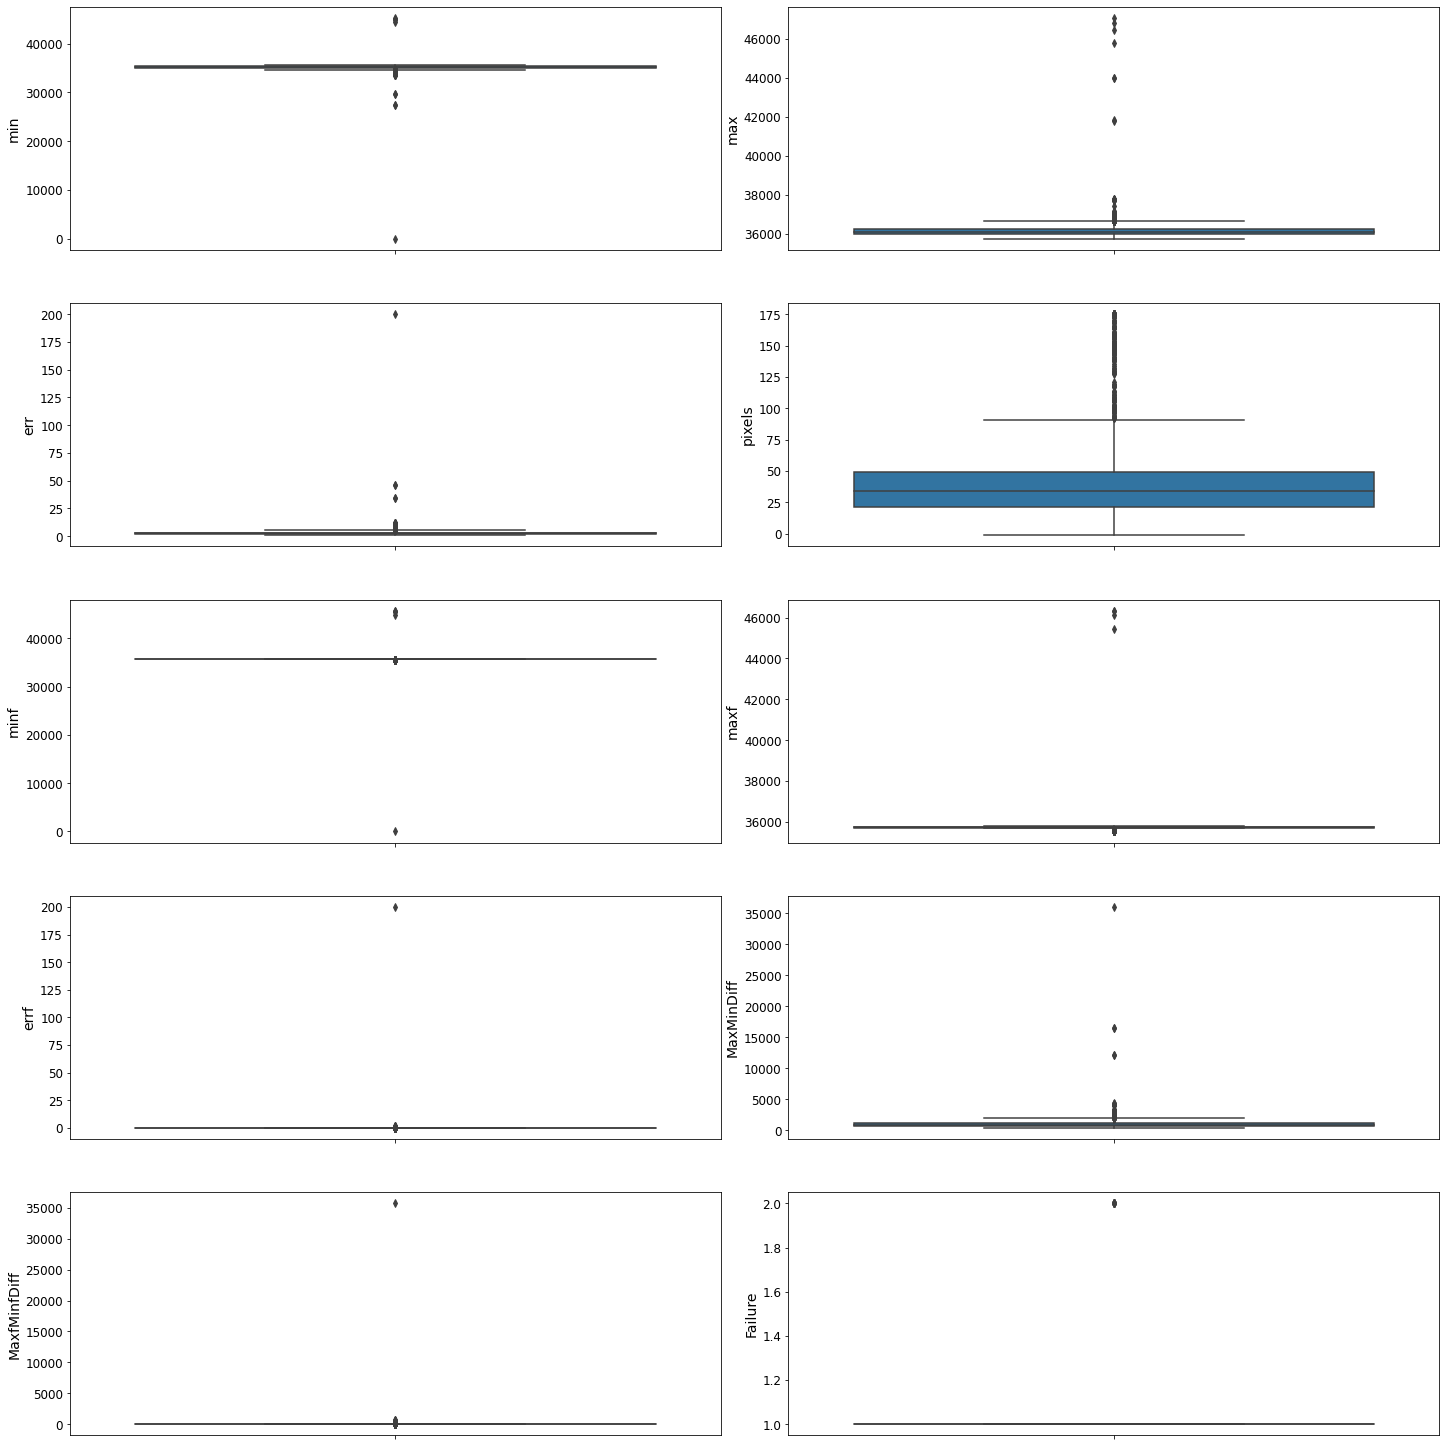

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 20))
index = 0
axs = axs.flatten()
for k,v in df_copy.items():
    sns.boxplot(y=k, data=df_copy, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

**NOTE: We can see that may columns data are not distributed properly, and they have many outliers, but we should not handle these outliers as they are failure cases and they are natural in this data.**

In [ ]:
df_copy.columns

Index(['min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf', 'MaxMinDiff',
       'MaxfMinfDiff', 'Failure'],
      dtype='object')

**Now, let's see the relationship between Pixels and Failure data**

In [ ]:
scat3 = px.scatter(df, x = 'pixels', y = 'Failure', color = 'scanner',
                  template = 'plotly_dark', title= 'pixels vs Failure', width=700, height=400)
scat3.show()

**NOTE: Pixels values does not impact Failure data.**

**Now let's check relationship between categorical data(Scanner) and Failure data.**

In [ ]:
#
# f, axes = plt.subplots(1, 1, figsize=(50, 35), facecolor='white')
# f.suptitle('Frequency of Categorical Features')
# sns.countplot(x="scanner", hue="Failure", data=df, palette="Blues")

bar = px.bar(df, x= 'scanner', y = 'Failure', color = 'Failure', template = 'gridon',
             title = 'Frequency of Categorical Features',
             width=900, height=500)
bar.show()

**NOTE:  From above, we can also determine that the dataset is not having all the failure cases of the scanners or only few of the scanners fail.**

In [ ]:
# Creating a new dataframe with categorical variables

cat_dummy = pd.get_dummies(df['scanner'], prefix = 'scanner', drop_first = False)

In [ ]:
cat_dummy

,scanner_H127,scanner_H128,scanner_H129,scanner_H130,scanner_H131,scanner_H132,scanner_H133,scanner_H134,scanner_H135,scanner_H138,...,scanner_K211,scanner_K212,scanner_K218,scanner_K219,scanner_K220,scanner_K221,scanner_K237,scanner_K238,scanner_K239,scanner_K250
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df_copy1 = pd.concat([df, cat_dummy], axis =1).drop(['scanner', 'updated_at'], axis = 1)

In [ ]:
df_copy1.head()

,min,max,err,pixels,minf,maxf,errf,MaxMinDiff,MaxfMinfDiff,Failure,...,scanner_K211,scanner_K212,scanner_K218,scanner_K219,scanner_K220,scanner_K221,scanner_K237,scanner_K238,scanner_K239,scanner_K250
0,35435,35933,1.40,6,35681,35688,0.02,498,7,1,...,0,0,0,1,0,0,0,0,0,0
1,35155,36382,3.43,14,35731,35761,0.08,1227,30,1,...,0,0,0,0,0,0,0,0,0,0
2,35305,36042,2.07,43,35692,35739,0.13,737,47,1,...,1,0,0,0,0,0,0,0,0,0
3,35216,36225,2.82,61,35686,35726,0.11,1009,40,1,...,0,1,0,0,0,0,0,0,0,0
4,35196,36259,2.98,11,35709,35724,0.04,1063,15,1,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df_copy1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 2751
Data columns (total 79 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   min           2603 non-null   int64  
 1   max           2603 non-null   int64  
 2   err           2603 non-null   float64
 3   pixels        2603 non-null   int64  
 4   minf          2603 non-null   int64  
 5   maxf          2603 non-null   int64  
 6   errf          2603 non-null   float64
 7   MaxMinDiff    2603 non-null   int64  
 8   MaxfMinfDiff  2603 non-null   int64  
 9   Failure       2603 non-null   int64  
 10  scanner_H127  2603 non-null   uint8  
 11  scanner_H128  2603 non-null   uint8  
 12  scanner_H129  2603 non-null   uint8  
 13  scanner_H130  2603 non-null   uint8  
 14  scanner_H131  2603 non-null   uint8  
 15  scanner_H132  2603 non-null   uint8  
 16  scanner_H133  2603 non-null   uint8  
 17  scanner_H134  2603 non-null   uint8  
 18  scanner_H135  2603 non-null 

In [ ]:
print(df_copy1['min'].min())
print(df_copy1['max'].min())
print(df_copy1['minf'].min())
print(df_copy1['maxf'].min())

-1
35761
-1
35527


**NOTE: We need to replace those negative value as those are not helpful for analysis and model building.**

In [ ]:
df_copy1['min'] = np.where(df_copy1['min']== -1, df_copy1['min'].mean(), df_copy1['min'])

In [ ]:
df_copy1['minf'] = np.where(df_copy1['minf'] == -1, df_copy1['minf'].mean(), df_copy1['minf'])

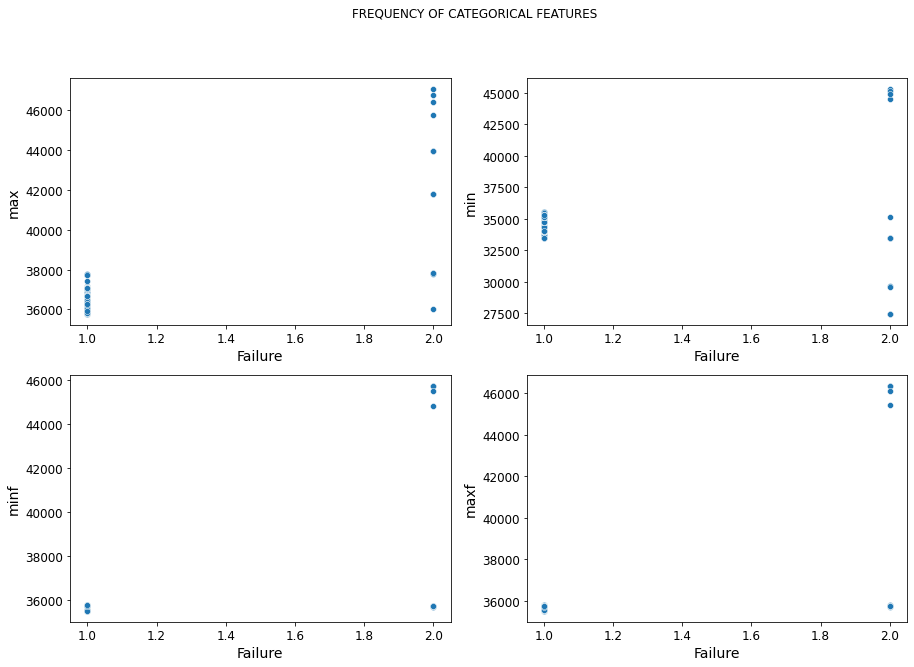

In [ ]:
f, axes = plt.subplots(2,2, figsize=(15, 10))
f.suptitle('FREQUENCY OF CATEGORICAL FEATURES')
fig1 = sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['max'],palette ="flare",ax=axes[0,0])
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['min'],palette ="crest", ax=axes[0,1])
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['minf'],palette ="rocket", ax=axes[1,0])
sns.scatterplot(x=df_copy1['Failure'],y=df_copy1['maxf'],palette ="cubehelix", ax=axes[1,1])

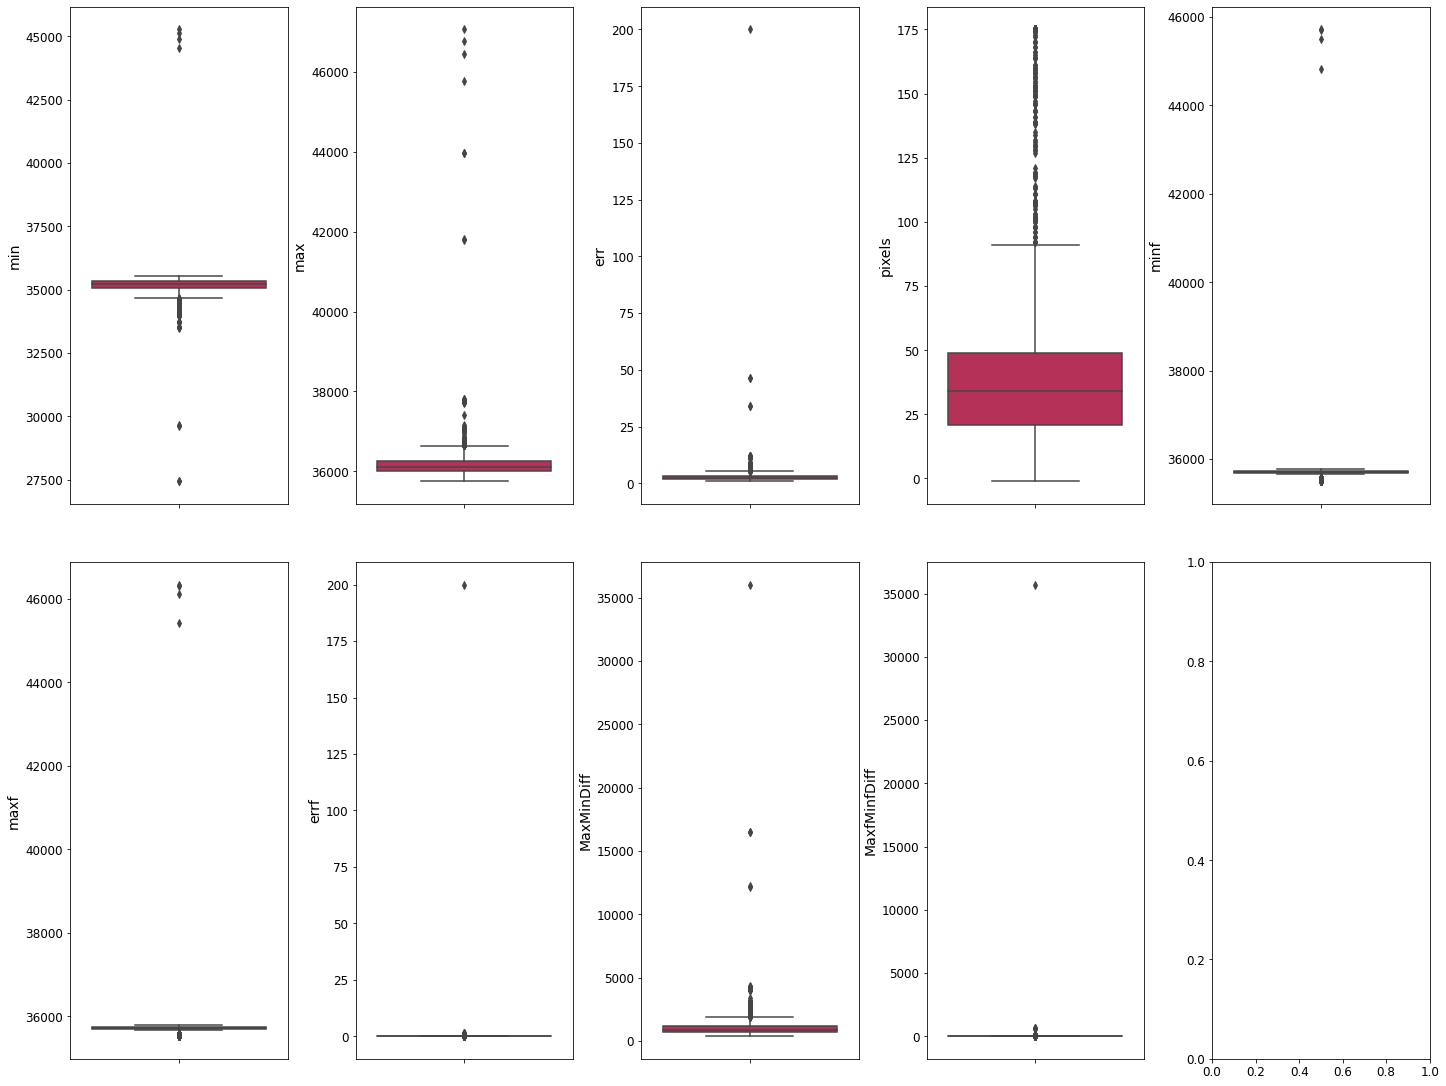

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 15))
index = 0
axs = axs.flatten()
for k,v in df_copy1.items():
    if k == 'updated_at':
      continue      
    elif k == 'Failure':
        break
    sns.boxplot(y=k, hue= 'Failure', palette = 'rocket',data=df_copy1, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
df_copy1.columns.size

79

# Final interpretation before modeling
**Err and Errf values are dependent on Max min difference of their respective parameters.**


*   Err value goes beyond 12% after approximate MaxMinDiff threshold value of 4283, which is failure of the device.
*    Errf value goes beyond 0.5% after approximate MaxMinDiff threshold value of 200, which is failure of the device.



**Let's define an extra category of failure**

**Failure category:**

*   Never fail : Failure = 1
*   Routinely fail: Failure = 2
*   Expected to fail/Failing faster: Failure = 3


In [ ]:
df_model = df_copy1.copy()

In [ ]:
df_copy1['Failure'] = np.where(((df_copy1['MaxMinDiff'] >= 4000) & (df_copy1['MaxMinDiff'] <= 4280)) |
                               ((df_copy1['MaxfMinfDiff'] >= 90) & (df_copy1['MaxfMinfDiff'] <= 120)),3, df_copy1['Failure'])

In [ ]:
df_copy1.Failure.value_counts()

1    2565
3      27
2      11
Name: Failure, dtype: int64

In [ ]:
sun = px.sunburst(df_copy1, path= ['Failure'], title = 'Number of different failure categories',
                  width = 400, height = 400)
sun.show()

# **Data Spliting & importing Libraries**

In [ ]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [ ]:
x = df_copy1.drop('Failure', axis = 1)
y = df_copy1['Failure']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.3, stratify = y, random_state = 45)

# **Model Generation and Prediction**

In [ ]:
def model_classifier(model):
      brk_str = '=='*50  
      parameters = {'n_estimators': [50, 150, 250],'max_depth': [4, 8, 16, 32, 64, None]}  
      print(brk_str)
      cv = GridSearchCV(model, param_grid=parameters, cv=10, n_jobs= -1)
      cv.fit(x_train, y_train)
      print(brk_str)
      print(cv.best_params_)
      print(brk_str)
      y_pred= cv.predict(x_test)
      print('Accuracy:', metrics.accuracy_score(y_pred,y_test))
     
      cv_scores =cross_val_score(cv, x, y, cv=5)
      print(brk_str)
      print(' Print the 5-fold cross-validation scores')
      print(brk_str)
      print(classification_report(y_test, y_pred))
      print()
      print("Average 5-Fold CV Score: {}".format(round(np.mean(cv_scores),4)),", Standard deviation: {}".format(round(np.std(cv_scores),4)))
      ConfMatrix = confusion_matrix(y_test,cv.predict(x_test))
      print()
      print(ConfMatrix)
      print()
      print(brk_str)

      print('Sample Test check')
      sample_test = df_copy1.loc[(df_copy1['scanner_K150'] == 1) & (df_copy1['Failure'] == 3)]
      ypred_sample = cv.predict(sample_test.drop(['Failure'],axis = 1))
      print(ypred_sample)
      print(brk_str)

# Random Forest Classifier

In [ ]:
model_classifier(RandomForestClassifier())

{'max_depth': 8, 'n_estimators': 250}
Accuracy: 0.9974391805377721
 Print the 5-fold cross-validation scores
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       770
           2       1.00      1.00      1.00         3
           3       0.80      1.00      0.89         8

    accuracy                           1.00       781
   macro avg       0.93      1.00      0.96       781
weighted avg       1.00      1.00      1.00       781


Average 5-Fold CV Score: 0.9969 , Standard deviation: 0.0026

[[768   0   2]
 [  0   3   0]
 [  0   0   8]]

Sample Test check
[3 3 3]


# Gradient Boosting Classifier

In [ ]:
model_classifier(GradientBoostingClassifier())

{'max_depth': 4, 'n_estimators': 50}
Accuracy: 0.9974391805377721
 Print the 5-fold cross-validation scores
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       770
           2       1.00      1.00      1.00         3
           3       0.80      1.00      0.89         8

    accuracy                           1.00       781
   macro avg       0.93      1.00      0.96       781
weighted avg       1.00      1.00      1.00       781


Average 5-Fold CV Score: 0.9977 , Standard deviation: 0.0022

[[768   0   2]
 [  0   3   0]
 [  0   0   8]]

Sample Test check
[3 3 3]


# Light Gbm Classifier

In [ ]:
lgbmc = lightgbm.LGBMClassifier()
model_classifier(lgbmc)

{'max_depth': 4, 'n_estimators': 150}
Accuracy: 0.9974391805377721
 Print the 5-fold cross-validation scores
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       770
           2       0.75      1.00      0.86         3
           3       1.00      0.75      0.86         8

    accuracy                           1.00       781
   macro avg       0.92      0.92      0.90       781
weighted avg       1.00      1.00      1.00       781


Average 5-Fold CV Score: 0.9958 , Standard deviation: 0.0026

[[770   0   0]
 [  0   3   0]
 [  1   1   6]]

Sample Test check
[2 2 3]


# **Conclusion**


1.   Based on the model estimation each model's accuracy and precision and recall values are satisfactory along with cross-validation scores
2.   LightGBM model gives results faster than Random Forest and Gradient Boosting.

